# Inaccurate testing

In this notebook, we relax the accurate testing assumption by accounting for the possibility of false positives and negatives in antigen testing. To do this, we incorporate two additional parameters into our model:

- The true positive rate (antigen test sensitivity)
- The true negative rate (antigen test specificity)

These are parameters are estimated within the model, and are pinned down by informative priors calibrated with data from the [Joint PHE Porton Down & University of Oxford SARS-CoV-2 test development and validation cell](https://www.ox.ac.uk/sites/files/oxford/media_wysiwyg/UK%20evaluation_PHE%20Porton%20Down%20%20University%20of%20Oxford_final.pdf). 

In [1]:
import time
import arviz
import numpy as np
import pandas as pd
import pystan

In [2]:
# Parameters
P = 10
N = 3*(10 ** 4)
SEED = 1729

In [3]:
# Ground truth
np.random.seed(SEED)
true_transmission_rate = np.random.beta(2, 10, P)
true_occurrence_rate = np.random.beta(2, 10, P)
base_rate = np.random.beta(2, 10, 1)

test_sensitivity = np.random.beta(4, 3, 1)  # True positive rate
test_specificity = np.random.beta(50, 2, 1)  # True negative rate
true_lambda = np.array([test_sensitivity, test_specificity])

In [4]:
# Simulate data
data = {}
for p in range(P):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    transmission = occurrence * np.random.binomial(1, true_transmission_rate[p], N)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission

data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
y = (z > 0).astype(int)

# Introducing false positives and negatives
y = y*np.random.binomial(1, true_lambda[0], N) + (1-y)*np.random.binomial(1, (1-true_lambda[1]), N)

X = X.loc[:, X.columns.str.startswith('O')]
X.info()


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   O1      30000 non-null  int64
 1   O2      30000 non-null  int64
 2   O3      30000 non-null  int64
 3   O4      30000 non-null  int64
 4   O5      30000 non-null  int64
 5   O6      30000 non-null  int64
 6   O7      30000 non-null  int64
 7   O8      30000 non-null  int64
 8   O9      30000 non-null  int64
 9   O10     30000 non-null  int64
dtypes: int64(10)
memory usage: 2.3 MB


In [5]:
# Create model
sm = pystan.StanModel(model_name='tt_imperfect_testing', model_code="""
data {
  int<lower=0> N;                            // number of test observations
  int<lower=0> P;                            // number of places
  int<lower=0, upper=1> X[N,P];              // activity occurrences of tested individuals
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
  real<lower=0, upper=1> mean_lambda[2];     // mean TP and TN test rates (for strong priors on tests)
  real<lower=0> se_lambda[2];                // standard error of test rates (for strong priors on tests)
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> rho;                // underlying risk
  real<lower=0, upper=1> lambda[2];          // True positive and true negative rates of tests [TP,TN]
}
model {
  // Precomputation
  real log1m_theta[P];
  real log1m_rho;
  real log_lambda[2];
  real log1m_lambda[2];
  real a_lambda[2];
  real b_lambda[2];
  
  for (p in 1:P) {
    log1m_theta[p] = log1m(theta[p]);
  }
  for(i in 1:2){
    log_lambda[i] = log(lambda[i]);
    log1m_lambda[i] = log1m(lambda[i]);
    
    a_lambda[i] = (((1-mean_lambda[i])/se_lambda[i]^2)-(1/mean_lambda[i]))*(mean_lambda[i]^2);
    b_lambda[i] = a_lambda[i]*((1/mean_lambda[i])-1);
  }
  
  log1m_rho = log1m(rho);
  
  // Priors
  theta ~ uniform(0, 1);
  rho ~ uniform(0, 1);
  lambda[1] ~ beta(a_lambda[1], b_lambda[1]);
  lambda[2] ~ beta(a_lambda[2], b_lambda[2]);

  // Likelihood
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    
    if (y[n] == 1) {
      target += log_sum_exp((log1m_exp(s) + log_lambda[1]), (s + log1m_lambda[2]));
    } 
    else {
      target += log_sum_exp((s + log_lambda[2]), (log1m_exp(s) + log1m_lambda[1]));
    }
  }
}
""")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL tt_mod_d55b3775665b9bac9ab9905164628dbf NOW.


### Note:
The means and standard error estimates used to create strong priors for antigen test accuracy are those reported by the [Joint PHE Porton Down & University of Oxford SARS-CoV-2 test development and validation cell](https://www.ox.ac.uk/sites/files/oxford/media_wysiwyg/UK%20evaluation_PHE%20Porton%20Down%20%20University%20of%20Oxford_final.pdf) 

In [6]:
# Set antigen test mean and std. error for TP and TN rates (for strong priors)

# True positive
mean_tp = 0.73000
se_tp = 0.04133

# True negative
mean_tn = 0.99680
se_tn = 0.00066

mean_rates = np.array([mean_tp, mean_tn])
se_rates = np.array([se_tp, se_tn])

In [7]:
# Set NUTS parameters
nuts_samples = 1000
nuts_burnin = 500
nuts_chains = 16

In [8]:
# Fit model
start = time.time()
model_data = {'N': N, 'P': P, 
              'X': X.to_numpy(), 'y': y.to_numpy(),
              'mean_lambda':mean_rates, 'se_lambda':se_rates}
fit = sm.sampling(
    data=model_data,
    iter=nuts_samples,
    warmup=nuts_burnin,
    chains=nuts_chains
)
print(f"{time.time() - start:.02f} seconds elapsed")

2265.20 seconds elapsed


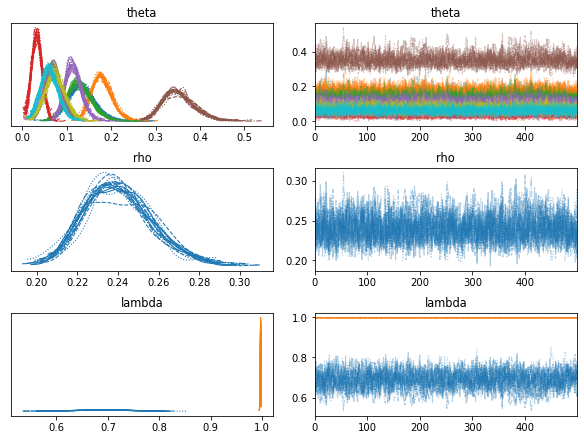

In [9]:
# Evaluate fit with test and trace resample
arviz.plot_trace(fit, figsize=(8, 6));

In [10]:
# View results
print("Inference on fitted model:")
print(fit)
print('')
print('Ground truth:')
print('Setting-specific transmission rates: ', true_transmission_rate)
print('Base rate: ', base_rate)
print('True positive and negative rates: ', true_lambda)

Inference on fitted model:
Inference for Stan model: tt_mod_d55b3775665b9bac9ab9905164628dbf.
16 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=8000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]    0.13  4.7e-4   0.03   0.08   0.11   0.13   0.15    0.2   3971    1.0
theta[2]    0.18  4.8e-4   0.02   0.14   0.16   0.18   0.19   0.23   2304    1.0
theta[3]    0.13  4.5e-4   0.03   0.08   0.11   0.13   0.15   0.19   3856    1.0
theta[4]    0.03  1.7e-4   0.01   0.01   0.02   0.03   0.04   0.06   5062    1.0
theta[5]    0.12  3.4e-4   0.02   0.08    0.1   0.11   0.13   0.16   2915    1.0
theta[6]    0.35  8.5e-4   0.04   0.29   0.33   0.35   0.37   0.43   1764   1.01
theta[7]    0.07  3.1e-4   0.02   0.03   0.05   0.07   0.08   0.11   5068    1.0
theta[8]    0.07  2.6e-4   0.02   0.04   0.06   0.07   0.08   0.11   5142    1.0
theta[9]    0.07  3.5e-4   0.02   0.03   0.06   0.07   0.09 